# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---


# Homework 1 - Supervised Deep Learning

# Regression task

## Guidelines

* The goal is to train a neural network to approximate an unknown function:
$$ 
f:\mathbb{R}→\mathbb{R} \\
x↦y=f(x) \\
\text{network}(x) \approx f(x)
$$
* As training point, you only have noisy measures from the target function.
$$
\hat{y} = f(x) + noise
$$
* Consider to create a validation set from you training data, or use a k-fold cross-validation strategy. You may find useful these functions from the `scikit-learn` library:
    - [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
    - [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) 

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
from torchvision import transforms
from sklearn.model_selection import KFold

In [2]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


## The Data
***

The following cell of code will download the dataset and make it available in the local folder `regression_dataset`. There are two files:

* `regression_dataset/train_data.csv`
* `regression_dataset/test_data.csv`

I will use them to train and test your model. Each row contains two values, respectively the input and the target (label).

In [3]:
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv 

--2022-07-01 13:52:14--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3776 (3.7K) [text/plain]
Saving to: ‘regression_dataset/train_data.csv’

train_data.csv      100%[===================>]   3.69K  --.-KB/s    in 0s      

2022-07-01 13:52:15 (69.4 MB/s) - ‘regression_dataset/train_data.csv’ saved [3776/3776]

--2022-07-01 13:52:15--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3788 (3.7K) [text/plain]
Saving to: ‘regression_dataset/test_data.csv’

test_data.csv 

## Dataset and Dataloader
***
I defining the `CsvDataset` class in order to generate a `Dataset` object from a csv file.
I therefore proceed to define the trasformation `ToTensor` and to create the training and test datasets. 


In [4]:
## Datasets
class CsvDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        # Read the file and split the lines in a list
        with open(csv_file, 'r') as f:
            lines = f.read().split('\n')
        # Get x and y values from each line and append to self.data
        self.data = []
        for line in lines:
            sample = line.split(',')
            try:
                self.data.append((float(sample[0]), float(sample[1])))
            except: pass
        # Now self.data contains all our dataset.
        # Each element of the list self.data is a tuple: (input, output)

    def __len__(self):
        # The length of the dataset is simply the length of the self.data list
        return len(self.data)

    def __getitem__(self, idx):
        # Our sample is the element idx of the list self.data
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample
    
## Transform
class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())

In [5]:
composed_transform = transforms.Compose([ToTensor()])

train_dataset = CsvDataset('regression_dataset/train_data.csv',transform=composed_transform)
test_dataset = CsvDataset('regression_dataset/test_data.csv',transform=composed_transform)

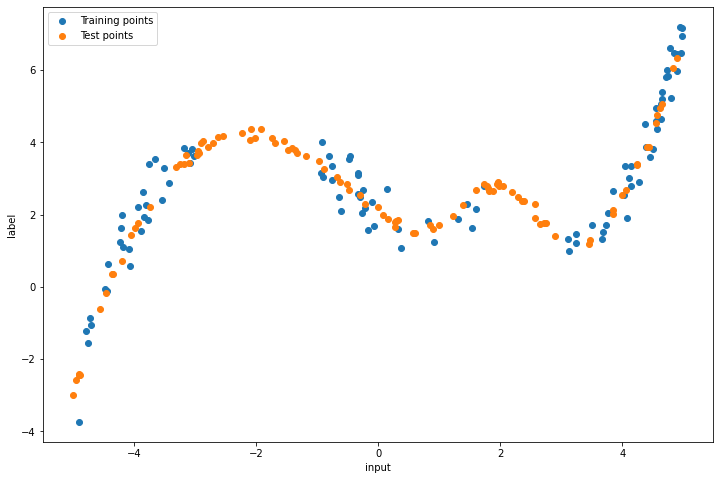

In [6]:
fig = plt.figure(figsize=(12,8))
plt.scatter(np.array(train_dataset.data)[:,0], np.array(train_dataset.data)[:,1], label='Training points')
plt.scatter(np.array(test_dataset.data)[:,0], np.array(test_dataset.data)[:,1], label='Test points')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.show()

## Network Definition
***

Here I define a fully connected Neural Network, and its functions to train and test the model.
The regressor is composed of:
* Input layer with $N_i(=1)$ neurons
* Hidden layer with $Nh_1$ neurons
* Hidden layer with $Nh_2$ neurons
* Output layer with $N_o(=1)$ neurons

At each hidden layer is applied a `ReLU` activation function and a `Dropout` layer, with probabilities $d_1$ and $d_2$, respectively for the first and the second.

In [7]:
class Net(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No, d1, d2):
        """
        Ni  - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No  - Output size
        d1  - 1st hidden layer Dropout probability
        d2  - 2nd hidden layer Dropout probability
        """
        super().__init__()
        
        print('Network initialized')
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        
        self.act = nn.ReLU()
        
        self.drop1 = nn.Dropout(p = d1)
        self.drop2 = nn.Dropout(p = d2)
        
    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.drop1(x)
        x = self.act(self.fc2(x))
        x = self.drop2(x)
        x = self.out(x)
        return x
    
    def train_epoch(self, train_dataloader, device, loss_fn, optimizer):
        '''
        train_dataloader - DataLoader containing the training data
        device           - torch.device
        loss_fn          - loss function torch.nn.modules.loss
        optimizer        - torch.optim
        ---
        RETURN           - float: training loss
        '''
        train_loss = []
        for sample_batched in train_dataloader:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            # Forward pass
            out = self(x_batch)

            # Compute loss
            loss = loss_fn(out, label_batch)

            # Backpropagation
            self.zero_grad()
            loss.backward()

            # Update the weights
            optimizer.step()

            # Save train loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)
        train_loss = np.mean(train_loss)
        return train_loss
        
    def eval_epoch(self, val_dataloader, device, loss_fn):
        '''
        val_dataloader - DataLoader containing the validation data
        device         - torch.device
        loss_fn        - loss function torch.nn.modules.loss
        ---
        RETURN         - float: validation loss
        '''
        val_loss = []
        for sample_batched in val_dataloader:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            # Forward pass
            out = self(x_batch)

            # Compute loss
            loss = loss_fn(out, label_batch)

            # Save val loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)
        val_loss = np.mean(val_loss)
        return val_loss
    
    def run_training(self, train_dataset, param_dict, val_dataset=None, plot=False):
        '''
        TRAIN THE MODEL WITH(OUT) VALIDATION
        -----
        train_dataset - DataSet containing the training data
        param_dict    - Dictionary of parameter. 
                        keys:{'epoch','device','loss_fn','optimizer'}
        val_dataset   - *DataSet: containing the validation data
                        *float: percentage of training data to use as validation
                        *None: (default) do not use validation data
        plot          - Bool: If True plot loss vs epochs
        -----
        RETURN        - lists of training and validation loss
        '''
        val_present = True
        if isinstance(val_dataset, float):
            N_val = int(len(train_dataset)*val_dataset)
            train_dataset, val_dataset = random_split(train_dataset, 
                                         lengths=[len(train_dataset)-N_val, N_val], 
                                         generator=torch.Generator().manual_seed(42))
            val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True, num_workers=0)
            train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=0)
        elif isinstance(val_dataset, CsvDataset):
            val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True, num_workers=0)
            train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=0)
        elif isinstance(val_dataset, DataLoader):
            val_dataloader  = val_dataset
            train_dataloader = train_dataset
        elif (val_dataset is None):
            val_present = False
            train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=0)
        else:
            print('val_dataset not valid')
        
        self.to(param_dict['device'])
        train_loss_log = ['---']
        val_loss_log = ['---']
        print('AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH')
        epochs = tqdm(range(param_dict['epochs']), leave=True)
        # LOOP START
        for epoch in epochs:
            epochs.set_description("%s         %s       %s" % (train_loss_log[-1], val_loss_log[-1], epoch))
            
            # Training
            self.train()
            train_loss = self.train_epoch(train_dataloader, param_dict['device'],
                                          param_dict['loss_fn'], param_dict['optimizer'])
            train_loss_log.append(train_loss)
            
            # Evaluation
            self.eval()
            val_loss = self.eval_epoch(val_dataloader, param_dict['device'], param_dict['loss_fn'])
            val_loss_log.append(val_loss)
            
        # Plotting
        if plot:
            plt.figure(figsize=(12,8))
            plt.semilogy(train_loss_log[1:], label='Train loss')
            if val_present: plt.semilogy(val_loss_log[1:], label='Validation loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.grid()
            plt.legend()
            plt.show()
        return train_loss_log[1:], val_loss_log[1:]
    
    def run_test(self, test_dataset, param_dict):
        '''
        TEST THE MODEL
        -----
        test_dataset - DataSet containing the test data
        param_dict   - Dictionary of parameter. 
                       keys:{'device','loss_fn'}
        -----
        RETURN       - np.array: predicted labels
                     - float: loss of predicted vs true label
        '''
        test_dataloader = DataLoader(test_dataset, shuffle=False, num_workers=0)
        self.eval()
        with torch.no_grad(): # turn off gradients computation
            val_loss = []
            out_list = []
            for sample_batched in test_dataloader:
                # Move data to device
                x_batch = sample_batched[0].to(param_dict['device'])
                label_batch = sample_batched[1].to(param_dict['device'])

                # Forward pass
                out = self(x_batch)

                # Compute loss
                loss = param_dict['loss_fn'](out, label_batch)

                # Save output and loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                out_batch = out.detach().cpu().numpy()
                val_loss.append(loss_batch)
                out_list.append(out_batch)
            val_loss = np.mean(val_loss)
        return np.array(out_list).flatten(), val_loss

def reset_weights(model):
    if isinstance(model, nn.Linear):
        model.reset_parameters()

## Trial Network
***

Now I define and train a simple network to test if everything works fine.
The network's hidden layer has 10 and 20 neurons respectively with 20% dropout probability.
I also produce `trial_params` dictionary, in order to store:
* number of epoch
* device
* loss function (Mean Square Error)
* optimizer (in this test will be Adam)

In [8]:
trial_net = Net(1,10,20,1, 0.2, 0.2)
trial_params = {'epochs' : 300,
                'device' : device,
                'loss_fn' : nn.MSELoss(),
                'optimizer' : optim.Adam(trial_net.parameters(), lr=1e-3)}

Network initialized


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.1349505         1.1349505       299: 100%|██████████| 300/300 [00:05<00:00, 50.47it/s]


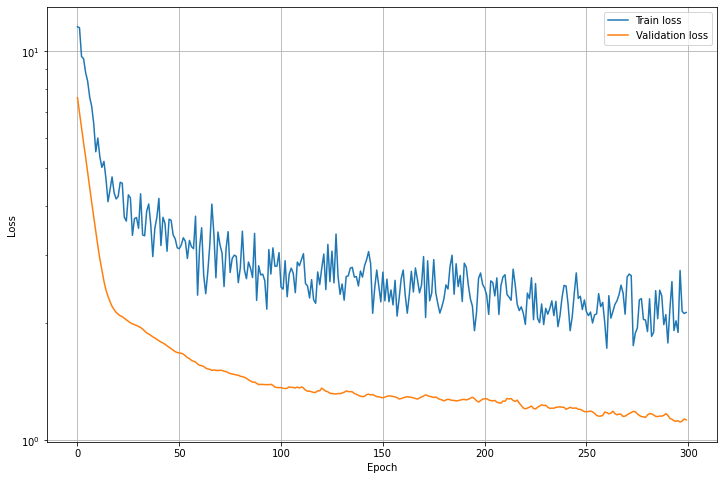

In [9]:
trial_train_loss, trial_val_loss = trial_net.run_training(train_dataset, trial_params, val_dataset=0.2, plot=True)

TEST LOSS = 1.466973066329956


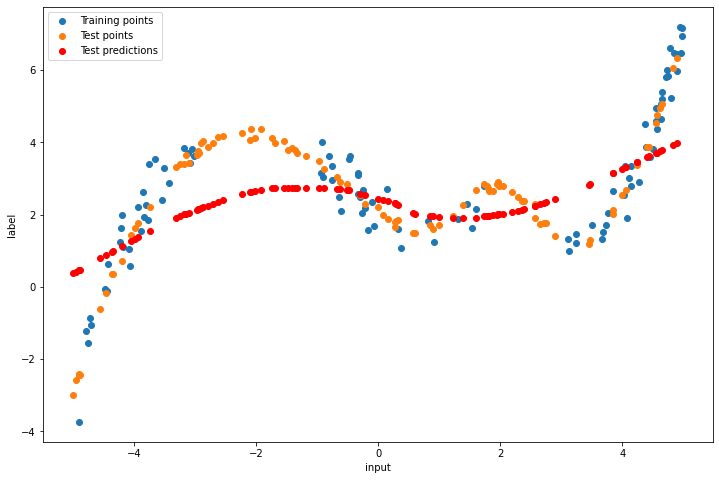

In [10]:
x_vec = torch.linspace(-5,5,1000)
x_vec = x_vec.to(device)
x_vec = x_vec.unsqueeze(-1)  # Adding a dimension to the input vector
trial_net.eval()
with torch.no_grad(): # turn off gradients computation
    y_vec = trial_net(x_vec)
test_prediction, test_loss = trial_net.run_test(test_dataset, trial_params)
print('TEST LOSS = %s' % float(test_loss))
fig = plt.figure(figsize=(12,8))
plt.scatter(np.array(train_dataset.data)[:,0], np.array(train_dataset.data)[:,1], label='Training points')
plt.scatter(np.array(test_dataset.data)[:,0], np.array(test_dataset.data)[:,1], label='Test points')
plt.scatter(np.array(test_dataset.data)[:,0], test_prediction, label='Test predictions', c='r')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.show()

It can be seen that the network has leant something, but there's still room for improvement.



## Hyperparameter Tuning
***
Now I want to find the best set of hyperparameter for the model, so I will perform a (random) GridSearch on:
* Hidden neurons
* Dropout probability
* Weight regularization
* Learning Rate
* optimizer
* epochs

Since the training data are few I will implement a K-fold Cross Validation in order to promote the generalization of the model.

In [11]:
def HPSampler(hp_dict):
    '''
    Function that samples the at random the hyperparameter to test.
    '''
    out = dict()
    for key, value in hp_dict.items():
        out[key] = np.random.choice(value)
    return out

def ModelFromHP(net_model, hyper_param, device):
    '''
    Initialize the Network and build the parameter dictionary
    ---
    net_model     - nn.Module
    hyper_param - dictionary with the actual hyperparameter
    device      - torch.device
    '''
    Nh1 = hyper_param['Nh1']
    Nh2 = hyper_param['Nh2']
    d1  = d2 = hyper_param['drop']
    wd  = hyper_param['wd']
    lr  = hyper_param['lr']
    ep  = hyper_param['epochs']
    ## Network Initialization
    actual_net = net_model(1,Nh1,Nh2,1, d1, d2)
    
    if (hyper_param['optim'] == 'sgd'):
        optimizer = optim.SGD(actual_net.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
    elif (hyper_param['optim'] == 'adam'):
        optimizer = optim.Adam(actual_net.parameters(), lr=lr, weight_decay=wd)
    else :
        print('Wrong optimizer')
    return actual_net, {'epochs' : ep,
                        'device' : device,
                        'loss_fn' : nn.MSELoss(),
                        'optimizer' : optimizer}

def GridSearchKFCV(net_model, train_dataset, hp_dict, k, N, device):
    '''
    RANDOM GRID SEARCH with K-Fold CROSS VALIDATION
    -----
    net_model     - nn.Module
    train_dataset - DataSet containing the training data
    hp_dict       - dictionary of the hyperparameter on 
                    which perform grid search
    k             - number of folds
    N             - number of different configuration to try
    device        - torch.device
    '''
    models = []
    best_loss = 1000
    for config in range(N):
        # Sample the hyperparameter configuration
        actual_hp = HPSampler(hp_dict)
        # Initialize the net
        actual_net, actual_params = ModelFromHP(net_model, actual_hp, device)
        #
        avg_train_loss = []
        avg_val_loss   = []
        kf = KFold(n_splits=k, shuffle=True)
        for kk, (train_ix,val_ix) in enumerate(kf.split(train_dataset)):
            # Reset model weights
            actual_net.apply(reset_weights)
            #
            train_sampler = SubsetRandomSampler(train_ix)
            val_sampler   = SubsetRandomSampler(val_ix)
            train_loader = DataLoader(train_dataset, batch_size=10, sampler=train_sampler)
            val_loader   = DataLoader(train_dataset, batch_size=10, sampler=val_sampler)
            # Train the model
            fold_train_loss, fold_val_loss = actual_net.run_training(train_loader, actual_params, val_dataset=val_loader, plot=False)
            # Append the losses
            avg_train_loss.append(fold_train_loss)
            avg_val_loss.append(fold_val_loss)
        avg_train_loss = np.mean(avg_train_loss, axis=0)
        avg_val_loss   = np.mean(avg_val_loss, axis=0)
        if (avg_val_loss[-1] < best_loss): 
            best_loss = avg_val_loss[-1]
            best_model = config
        models.append({'hp_dict': actual_hp,
                       'train_loss': avg_train_loss,
                       'val_loss'  : avg_val_loss})
    return models, best_model

In [12]:
hyper_dict = {'Nh1'   : [10, 20, 30, 40, 50], 
              'Nh2'   : [25, 50, 75, 100],
              'drop'  : np.linspace(0.15,0.5,100),
              'wd'    : np.logspace(-4,-2,100),
              'lr'    : np.logspace(-4,-2,100),
              'optim' : ['sgd', 'adam'],
              'epochs': [100,200,300]}

In [13]:
model_list, best_model = GridSearchKFCV(Net, train_dataset, hyper_dict, 4, 100, device)

Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.1691569         1.1691569       99: 100%|██████████| 100/100 [00:02<00:00, 47.33it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.1433783         2.1433783       99: 100%|██████████| 100/100 [00:02<00:00, 47.09it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.5231247         3.5231247       99: 100%|██████████| 100/100 [00:02<00:00, 47.04it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.3745894         2.3745894       99: 100%|██████████| 100/100 [00:02<00:00, 47.20it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.74056023         0.74056023       99: 100%|██████████| 100/100 [00:02<00:00, 47.05it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.7534779         0.7534779       99: 100%|██████████| 100/100 [00:02<00:00, 47.16it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.0843271         1.0843271       99: 100%|██████████| 100/100 [00:02<00:00, 47.26it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.6870371         1.6870371       99: 100%|██████████| 100/100 [00:02<00:00, 46.79it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.492005         2.492005       99: 100%|██████████| 100/100 [00:02<00:00, 45.97it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.74037         2.74037       99: 100%|██████████| 100/100 [00:02<00:00, 47.78it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.9537728         2.9537728       99: 100%|██████████| 100/100 [00:02<00:00, 46.73it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.1860472         1.1860472       99: 100%|██████████| 100/100 [00:02<00:00, 46.66it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


6.415867         6.415867       299: 100%|██████████| 300/300 [00:05<00:00, 53.14it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.8303471         1.8303471       299: 100%|██████████| 300/300 [00:05<00:00, 52.86it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.4865437         2.4865437       299: 100%|██████████| 300/300 [00:05<00:00, 52.26it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.539363         2.539363       299: 100%|██████████| 300/300 [00:05<00:00, 53.33it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.077532         2.077532       99: 100%|██████████| 100/100 [00:02<00:00, 44.05it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.3478723         2.3478723       99: 100%|██████████| 100/100 [00:02<00:00, 46.92it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.067931         3.067931       99: 100%|██████████| 100/100 [00:02<00:00, 46.78it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.608422         2.608422       99: 100%|██████████| 100/100 [00:02<00:00, 46.76it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.8167486         1.8167486       199: 100%|██████████| 200/200 [00:04<00:00, 47.13it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.2418681         1.2418681       199: 100%|██████████| 200/200 [00:04<00:00, 47.37it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.8346613         0.8346613       199: 100%|██████████| 200/200 [00:04<00:00, 46.88it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.13099         2.13099       199: 100%|██████████| 200/200 [00:05<00:00, 38.29it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.5160159         1.5160159       199: 100%|██████████| 200/200 [00:04<00:00, 46.76it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.4196144         1.4196144       199: 100%|██████████| 200/200 [00:04<00:00, 47.17it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.6324458         0.6324458       199: 100%|██████████| 200/200 [00:04<00:00, 46.77it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.8126889         0.8126889       199: 100%|██████████| 200/200 [00:04<00:00, 46.82it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.5342133         2.5342133       299: 100%|██████████| 300/300 [00:06<00:00, 45.90it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.009523         2.009523       299: 100%|██████████| 300/300 [00:06<00:00, 46.82it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.90283185         0.90283185       299: 100%|██████████| 300/300 [00:06<00:00, 46.60it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.4965134         2.4965134       299: 100%|██████████| 300/300 [00:06<00:00, 46.49it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.1305888         3.1305888       199: 100%|██████████| 200/200 [00:04<00:00, 46.74it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


4.1360183         4.1360183       199: 100%|██████████| 200/200 [00:04<00:00, 46.84it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.1265287         3.1265287       199: 100%|██████████| 200/200 [00:04<00:00, 47.20it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.8529613         2.8529613       199: 100%|██████████| 200/200 [00:04<00:00, 43.01it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.1628205         1.1628205       199: 100%|██████████| 200/200 [00:04<00:00, 47.24it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.6557721         1.6557721       199: 100%|██████████| 200/200 [00:04<00:00, 46.93it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.3758066         2.3758066       199: 100%|██████████| 200/200 [00:04<00:00, 47.10it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.6440006         1.6440006       199: 100%|██████████| 200/200 [00:04<00:00, 46.99it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.653234         2.653234       199: 100%|██████████| 200/200 [00:03<00:00, 53.97it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.57658577         0.57658577       199: 100%|██████████| 200/200 [00:03<00:00, 54.33it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.4637202         1.4637202       199: 100%|██████████| 200/200 [00:03<00:00, 53.68it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.99325675         0.99325675       199: 100%|██████████| 200/200 [00:03<00:00, 54.03it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.4002498         1.4002498       99: 100%|██████████| 100/100 [00:01<00:00, 53.65it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.3578663         1.3578663       99: 100%|██████████| 100/100 [00:01<00:00, 53.69it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.8559279         0.8559279       99: 100%|██████████| 100/100 [00:01<00:00, 53.88it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.476579         2.476579       99: 100%|██████████| 100/100 [00:01<00:00, 53.19it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.6398196         2.6398196       99: 100%|██████████| 100/100 [00:01<00:00, 52.62it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.5896704         2.5896704       99: 100%|██████████| 100/100 [00:01<00:00, 52.52it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.1776354         2.1776354       99: 100%|██████████| 100/100 [00:01<00:00, 53.33it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.9619544         2.9619544       99: 100%|██████████| 100/100 [00:01<00:00, 53.36it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.2052186         2.2052186       199: 100%|██████████| 200/200 [00:04<00:00, 45.94it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.3874366         3.3874366       199: 100%|██████████| 200/200 [00:04<00:00, 46.38it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.9843607         2.9843607       199: 100%|██████████| 200/200 [00:04<00:00, 46.93it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.3143291         2.3143291       199: 100%|██████████| 200/200 [00:04<00:00, 46.88it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.2152185         1.2152185       299: 100%|██████████| 300/300 [00:06<00:00, 46.91it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.6302147         1.6302147       299: 100%|██████████| 300/300 [00:06<00:00, 46.75it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.5214745         1.5214745       299: 100%|██████████| 300/300 [00:06<00:00, 46.79it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.8119152         0.8119152       299: 100%|██████████| 300/300 [00:06<00:00, 46.96it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.7894151         2.7894151       99: 100%|██████████| 100/100 [00:02<00:00, 46.10it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.20832         1.20832       99: 100%|██████████| 100/100 [00:02<00:00, 47.50it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.4588503         1.4588503       99: 100%|██████████| 100/100 [00:02<00:00, 47.40it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.643093         3.643093       99: 100%|██████████| 100/100 [00:02<00:00, 46.44it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.22977668         0.22977668       199: 100%|██████████| 200/200 [00:04<00:00, 46.26it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.6778781         0.6778781       199: 100%|██████████| 200/200 [00:04<00:00, 46.82it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.39681295         0.39681295       199: 100%|██████████| 200/200 [00:04<00:00, 46.71it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.20917885         0.20917885       199: 100%|██████████| 200/200 [00:04<00:00, 46.32it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.0166752         2.0166752       99: 100%|██████████| 100/100 [00:01<00:00, 53.16it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.5070015         1.5070015       99: 100%|██████████| 100/100 [00:01<00:00, 53.68it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.165889         2.165889       99: 100%|██████████| 100/100 [00:01<00:00, 52.91it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.6447814         2.6447814       99: 100%|██████████| 100/100 [00:01<00:00, 52.87it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.9892591         1.9892591       99: 100%|██████████| 100/100 [00:01<00:00, 51.89it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.7446007         1.7446007       99: 100%|██████████| 100/100 [00:01<00:00, 53.59it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.022454         2.022454       99: 100%|██████████| 100/100 [00:01<00:00, 52.50it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.7249897         2.7249897       99: 100%|██████████| 100/100 [00:01<00:00, 53.07it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.0793439         1.0793439       99: 100%|██████████| 100/100 [00:02<00:00, 45.70it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.099692         1.099692       99: 100%|██████████| 100/100 [00:02<00:00, 46.35it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.1405861         3.1405861       99: 100%|██████████| 100/100 [00:02<00:00, 46.14it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.1651973         1.1651973       99: 100%|██████████| 100/100 [00:02<00:00, 47.12it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.543254         2.543254       99: 100%|██████████| 100/100 [00:02<00:00, 46.07it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.700999         3.700999       99: 100%|██████████| 100/100 [00:02<00:00, 46.09it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.9839308         2.9839308       99: 100%|██████████| 100/100 [00:02<00:00, 46.46it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.669811         2.669811       99: 100%|██████████| 100/100 [00:02<00:00, 46.55it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.5602175         1.5602175       99: 100%|██████████| 100/100 [00:01<00:00, 53.12it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.4326706         2.4326706       99: 100%|██████████| 100/100 [00:01<00:00, 52.46it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.8649425         0.8649425       99: 100%|██████████| 100/100 [00:01<00:00, 53.64it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.2805023         2.2805023       99: 100%|██████████| 100/100 [00:01<00:00, 53.18it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.3734539         2.3734539       199: 100%|██████████| 200/200 [00:03<00:00, 52.92it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.422837         3.422837       199: 100%|██████████| 200/200 [00:03<00:00, 53.08it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


4.7409215         4.7409215       199: 100%|██████████| 200/200 [00:03<00:00, 53.40it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


4.0845194         4.0845194       199: 100%|██████████| 200/200 [00:03<00:00, 52.80it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


4.8126197         4.8126197       199: 100%|██████████| 200/200 [00:03<00:00, 52.45it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.7977633         0.7977633       199: 100%|██████████| 200/200 [00:03<00:00, 52.32it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.7626511         1.7626511       199: 100%|██████████| 200/200 [00:03<00:00, 52.87it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.509682         1.509682       199: 100%|██████████| 200/200 [00:03<00:00, 52.81it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.4870656         2.4870656       199: 100%|██████████| 200/200 [00:04<00:00, 46.11it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.1652868         2.1652868       199: 100%|██████████| 200/200 [00:04<00:00, 46.13it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.8069429         1.8069429       199: 100%|██████████| 200/200 [00:04<00:00, 46.45it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.2323635         3.2323635       199: 100%|██████████| 200/200 [00:04<00:00, 46.12it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.9312826         0.9312826       199: 100%|██████████| 200/200 [00:04<00:00, 45.15it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.89080405         0.89080405       199: 100%|██████████| 200/200 [00:04<00:00, 44.80it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.54025567         0.54025567       199: 100%|██████████| 200/200 [00:04<00:00, 45.19it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.51207703         0.51207703       199: 100%|██████████| 200/200 [00:04<00:00, 45.64it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.3511856         3.3511856       99: 100%|██████████| 100/100 [00:02<00:00, 46.08it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.8903322         2.8903322       99: 100%|██████████| 100/100 [00:02<00:00, 46.70it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.7573586         3.7573586       99: 100%|██████████| 100/100 [00:02<00:00, 46.17it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.2310007         2.2310007       99: 100%|██████████| 100/100 [00:02<00:00, 45.59it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.2837618         0.2837618       199: 100%|██████████| 200/200 [00:04<00:00, 45.74it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.37580904         0.37580904       199: 100%|██████████| 200/200 [00:04<00:00, 46.88it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.48907566         0.48907566       199: 100%|██████████| 200/200 [00:04<00:00, 46.06it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.8158609         0.8158609       199: 100%|██████████| 200/200 [00:04<00:00, 46.08it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.8910335         1.8910335       199: 100%|██████████| 200/200 [00:03<00:00, 53.24it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.1637042         3.1637042       199: 100%|██████████| 200/200 [00:03<00:00, 51.15it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.5208845         3.5208845       199: 100%|██████████| 200/200 [00:04<00:00, 48.53it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.3294532         3.3294532       199: 100%|██████████| 200/200 [00:03<00:00, 52.74it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.5958638         0.5958638       199: 100%|██████████| 200/200 [00:04<00:00, 45.86it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.4173598         0.4173598       199: 100%|██████████| 200/200 [00:04<00:00, 46.26it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.7232292         0.7232292       199: 100%|██████████| 200/200 [00:04<00:00, 45.56it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.79060316         0.79060316       199: 100%|██████████| 200/200 [00:04<00:00, 45.81it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.9563146         0.9563146       299: 100%|██████████| 300/300 [00:06<00:00, 45.74it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.305858         0.305858       299: 100%|██████████| 300/300 [00:06<00:00, 44.87it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.7841938         0.7841938       299: 100%|██████████| 300/300 [00:06<00:00, 45.45it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.2274585         1.2274585       299: 100%|██████████| 300/300 [00:06<00:00, 45.59it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.2489345         2.2489345       99: 100%|██████████| 100/100 [00:02<00:00, 49.59it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.0576751         3.0576751       99: 100%|██████████| 100/100 [00:01<00:00, 52.09it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.2063851         1.2063851       99: 100%|██████████| 100/100 [00:01<00:00, 52.44it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.46686         2.46686       99: 100%|██████████| 100/100 [00:01<00:00, 52.20it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.5236132         2.5236132       199: 100%|██████████| 200/200 [00:04<00:00, 45.73it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.4830818         3.4830818       199: 100%|██████████| 200/200 [00:04<00:00, 45.60it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.1979084         2.1979084       199: 100%|██████████| 200/200 [00:04<00:00, 46.27it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.0786483         3.0786483       199: 100%|██████████| 200/200 [00:04<00:00, 45.78it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.92889196         0.92889196       299: 100%|██████████| 300/300 [00:05<00:00, 52.32it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.6547941         1.6547941       299: 100%|██████████| 300/300 [00:05<00:00, 51.96it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.5710176         1.5710176       299: 100%|██████████| 300/300 [00:05<00:00, 51.70it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.9312307         0.9312307       299: 100%|██████████| 300/300 [00:05<00:00, 51.98it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.274655         2.274655       199: 100%|██████████| 200/200 [00:04<00:00, 45.53it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.5084956         2.5084956       199: 100%|██████████| 200/200 [00:04<00:00, 45.71it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.5239909         2.5239909       199: 100%|██████████| 200/200 [00:04<00:00, 45.46it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.8737491         0.8737491       199: 100%|██████████| 200/200 [00:04<00:00, 45.30it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.9982716         1.9982716       199: 100%|██████████| 200/200 [00:04<00:00, 45.67it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.0117404         3.0117404       199: 100%|██████████| 200/200 [00:04<00:00, 45.05it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


4.0695424         4.0695424       199: 100%|██████████| 200/200 [00:04<00:00, 45.79it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.6464622         2.6464622       199: 100%|██████████| 200/200 [00:04<00:00, 45.45it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.6916075         1.6916075       299: 100%|██████████| 300/300 [00:06<00:00, 45.51it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.1761703         3.1761703       299: 100%|██████████| 300/300 [00:06<00:00, 44.91it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.0761006         2.0761006       299: 100%|██████████| 300/300 [00:06<00:00, 45.03it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.4148277         1.4148277       299: 100%|██████████| 300/300 [00:06<00:00, 45.30it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.3891734         1.3891734       299: 100%|██████████| 300/300 [00:05<00:00, 52.08it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.5249289         0.5249289       299: 100%|██████████| 300/300 [00:05<00:00, 51.63it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.4109044         1.4109044       299: 100%|██████████| 300/300 [00:05<00:00, 50.84it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.0137848         1.0137848       299: 100%|██████████| 300/300 [00:05<00:00, 51.17it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.4687996         2.4687996       299: 100%|██████████| 300/300 [00:05<00:00, 50.59it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.6807292         3.6807292       299: 100%|██████████| 300/300 [00:06<00:00, 48.66it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.9226851         1.9226851       299: 100%|██████████| 300/300 [00:06<00:00, 49.60it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.9162733         0.9162733       299: 100%|██████████| 300/300 [00:06<00:00, 49.99it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.6826727         2.6826727       299: 100%|██████████| 300/300 [00:05<00:00, 50.11it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.2959194         3.2959194       299: 100%|██████████| 300/300 [00:06<00:00, 49.28it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.3411179         1.3411179       299: 100%|██████████| 300/300 [00:06<00:00, 49.69it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.5097554         2.5097554       299: 100%|██████████| 300/300 [00:05<00:00, 51.01it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.6980889         0.6980889       299: 100%|██████████| 300/300 [00:05<00:00, 51.55it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.2295519         1.2295519       299: 100%|██████████| 300/300 [00:05<00:00, 51.61it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.4539934         0.4539934       299: 100%|██████████| 300/300 [00:05<00:00, 51.57it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.45310488         0.45310488       299: 100%|██████████| 300/300 [00:06<00:00, 48.73it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.717682         1.717682       199: 100%|██████████| 200/200 [00:04<00:00, 49.45it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.3011856         1.3011856       199: 100%|██████████| 200/200 [00:04<00:00, 49.32it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.1058726         2.1058726       199: 100%|██████████| 200/200 [00:03<00:00, 50.26it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.9278116         2.9278116       199: 100%|██████████| 200/200 [00:03<00:00, 50.33it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.7409892         1.7409892       99: 100%|██████████| 100/100 [00:02<00:00, 43.97it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.7807735         1.7807735       99: 100%|██████████| 100/100 [00:02<00:00, 44.67it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.4410359         1.4410359       99: 100%|██████████| 100/100 [00:02<00:00, 45.14it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.0536091         3.0536091       99: 100%|██████████| 100/100 [00:02<00:00, 44.67it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.5933829         0.5933829       199: 100%|██████████| 200/200 [00:04<00:00, 43.96it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.7535682         0.7535682       199: 100%|██████████| 200/200 [00:04<00:00, 45.42it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.7456677         0.7456677       199: 100%|██████████| 200/200 [00:04<00:00, 44.80it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.5061371         0.5061371       199: 100%|██████████| 200/200 [00:04<00:00, 44.53it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.8368905         3.8368905       99: 100%|██████████| 100/100 [00:01<00:00, 50.80it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.0060554         2.0060554       99: 100%|██████████| 100/100 [00:02<00:00, 49.81it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


5.0514154         5.0514154       99: 100%|██████████| 100/100 [00:01<00:00, 50.12it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.6656826         3.6656826       99: 100%|██████████| 100/100 [00:01<00:00, 50.78it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.51257735         0.51257735       99: 100%|██████████| 100/100 [00:02<00:00, 44.69it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.6444144         0.6444144       99: 100%|██████████| 100/100 [00:02<00:00, 44.52it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.3517057         1.3517057       99: 100%|██████████| 100/100 [00:02<00:00, 44.93it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.0756804         1.0756804       99: 100%|██████████| 100/100 [00:02<00:00, 44.55it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.5137196         3.5137196       299: 100%|██████████| 300/300 [00:05<00:00, 51.04it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.4410546         2.4410546       299: 100%|██████████| 300/300 [00:05<00:00, 50.55it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.4491218         1.4491218       299: 100%|██████████| 300/300 [00:05<00:00, 51.24it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.8116658         2.8116658       299: 100%|██████████| 300/300 [00:05<00:00, 50.47it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.0639032         1.0639032       199: 100%|██████████| 200/200 [00:03<00:00, 50.78it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.6527891         1.6527891       199: 100%|██████████| 200/200 [00:03<00:00, 50.23it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.5383434         1.5383434       199: 100%|██████████| 200/200 [00:03<00:00, 50.03it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.9888388         1.9888388       199: 100%|██████████| 200/200 [00:04<00:00, 49.12it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.8593922         1.8593922       299: 100%|██████████| 300/300 [00:06<00:00, 49.66it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.1563596         1.1563596       299: 100%|██████████| 300/300 [00:05<00:00, 50.52it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.6654499         3.6654499       299: 100%|██████████| 300/300 [00:05<00:00, 51.26it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.251901         2.251901       299: 100%|██████████| 300/300 [00:05<00:00, 51.06it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.2812917         2.2812917       299: 100%|██████████| 300/300 [00:05<00:00, 50.44it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.4554088         2.4554088       299: 100%|██████████| 300/300 [00:05<00:00, 50.92it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.4867897         3.4867897       299: 100%|██████████| 300/300 [00:05<00:00, 51.14it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.3312902         2.3312902       299: 100%|██████████| 300/300 [00:05<00:00, 50.81it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.7318964         1.7318964       299: 100%|██████████| 300/300 [00:05<00:00, 50.79it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.9072254         2.9072254       299: 100%|██████████| 300/300 [00:06<00:00, 49.82it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.2279962         1.2279962       299: 100%|██████████| 300/300 [00:05<00:00, 50.10it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.8918095         0.8918095       299: 100%|██████████| 300/300 [00:05<00:00, 50.24it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.9374022         1.9374022       99: 100%|██████████| 100/100 [00:01<00:00, 50.41it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.32078         3.32078       99: 100%|██████████| 100/100 [00:02<00:00, 49.32it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.6873424         2.6873424       99: 100%|██████████| 100/100 [00:01<00:00, 50.16it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.5458423         1.5458423       99: 100%|██████████| 100/100 [00:02<00:00, 49.86it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.9965612         1.9965612       99: 100%|██████████| 100/100 [00:02<00:00, 43.99it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.9192312         0.9192312       99: 100%|██████████| 100/100 [00:02<00:00, 43.96it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.4369366         3.4369366       99: 100%|██████████| 100/100 [00:02<00:00, 43.84it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.6684258         2.6684258       99: 100%|██████████| 100/100 [00:02<00:00, 44.35it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.3399558         2.3399558       199: 100%|██████████| 200/200 [00:03<00:00, 50.21it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.8378544         2.8378544       199: 100%|██████████| 200/200 [00:03<00:00, 50.80it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.309187         2.309187       199: 100%|██████████| 200/200 [00:03<00:00, 50.29it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.488561         2.488561       199: 100%|██████████| 200/200 [00:03<00:00, 50.73it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.0558524         1.0558524       299: 100%|██████████| 300/300 [00:06<00:00, 44.80it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.186597         2.186597       299: 100%|██████████| 300/300 [00:06<00:00, 44.38it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.0037355         2.0037355       299: 100%|██████████| 300/300 [00:06<00:00, 44.58it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.2256789         1.2256789       299: 100%|██████████| 300/300 [00:06<00:00, 44.38it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.29474628         0.29474628       299: 100%|██████████| 300/300 [00:06<00:00, 44.53it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.9394822         0.9394822       299: 100%|██████████| 300/300 [00:06<00:00, 44.25it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.51687294         0.51687294       299: 100%|██████████| 300/300 [00:06<00:00, 44.18it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.6353436         0.6353436       299: 100%|██████████| 300/300 [00:06<00:00, 44.50it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.59359497         0.59359497       299: 100%|██████████| 300/300 [00:07<00:00, 41.39it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.7030106         1.7030106       299: 100%|██████████| 300/300 [00:06<00:00, 43.80it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.3403832         1.3403832       299: 100%|██████████| 300/300 [00:06<00:00, 43.96it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.85563356         0.85563356       299: 100%|██████████| 300/300 [00:06<00:00, 43.82it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.94948345         0.94948345       99: 100%|██████████| 100/100 [00:01<00:00, 50.00it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.7641966         0.7641966       99: 100%|██████████| 100/100 [00:02<00:00, 49.67it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.0445576         3.0445576       99: 100%|██████████| 100/100 [00:01<00:00, 50.89it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.9758026         0.9758026       99: 100%|██████████| 100/100 [00:01<00:00, 50.36it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.6061108         3.6061108       99: 100%|██████████| 100/100 [00:01<00:00, 50.47it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.393861         2.393861       99: 100%|██████████| 100/100 [00:02<00:00, 49.97it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.1139278         3.1139278       99: 100%|██████████| 100/100 [00:01<00:00, 50.39it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.7388833         3.7388833       99: 100%|██████████| 100/100 [00:01<00:00, 50.12it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.2895496         0.2895496       199: 100%|██████████| 200/200 [00:04<00:00, 43.38it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.5804806         0.5804806       199: 100%|██████████| 200/200 [00:04<00:00, 44.28it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.3517127         0.3517127       199: 100%|██████████| 200/200 [00:04<00:00, 42.91it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.72775406         0.72775406       199: 100%|██████████| 200/200 [00:04<00:00, 43.41it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.6596699         3.6596699       99: 100%|██████████| 100/100 [00:02<00:00, 41.55it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.1297143         2.1297143       99: 100%|██████████| 100/100 [00:02<00:00, 42.77it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.1008985         2.1008985       99: 100%|██████████| 100/100 [00:02<00:00, 43.18it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


4.415548         4.415548       99: 100%|██████████| 100/100 [00:02<00:00, 43.67it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.3346498         3.3346498       199: 100%|██████████| 200/200 [00:04<00:00, 43.78it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.8860031         1.8860031       199: 100%|██████████| 200/200 [00:04<00:00, 44.09it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.5016549         2.5016549       199: 100%|██████████| 200/200 [00:04<00:00, 43.19it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.0946047         2.0946047       199: 100%|██████████| 200/200 [00:04<00:00, 43.45it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.8691692         2.8691692       299: 100%|██████████| 300/300 [00:06<00:00, 43.67it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.3161104         2.3161104       299: 100%|██████████| 300/300 [00:06<00:00, 44.42it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.6552885         2.6552885       299: 100%|██████████| 300/300 [00:06<00:00, 44.76it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.535945         1.535945       299: 100%|██████████| 300/300 [00:06<00:00, 43.94it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.0399513         2.0399513       99: 100%|██████████| 100/100 [00:02<00:00, 43.85it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.730732         2.730732       99: 100%|██████████| 100/100 [00:02<00:00, 44.06it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.3795254         2.3795254       99: 100%|██████████| 100/100 [00:02<00:00, 44.37it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.0083134         3.0083134       99: 100%|██████████| 100/100 [00:02<00:00, 44.39it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.8242246         1.8242246       299: 100%|██████████| 300/300 [00:06<00:00, 49.78it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.0933692         2.0933692       299: 100%|██████████| 300/300 [00:06<00:00, 49.83it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.9123106         0.9123106       299: 100%|██████████| 300/300 [00:05<00:00, 50.08it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.82956177         0.82956177       299: 100%|██████████| 300/300 [00:05<00:00, 50.03it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.0203454         2.0203454       199: 100%|██████████| 200/200 [00:04<00:00, 49.94it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.410553         2.410553       199: 100%|██████████| 200/200 [00:04<00:00, 49.99it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.3236048         2.3236048       199: 100%|██████████| 200/200 [00:04<00:00, 49.96it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.0912191         1.0912191       199: 100%|██████████| 200/200 [00:04<00:00, 49.43it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.961877         2.961877       299: 100%|██████████| 300/300 [00:05<00:00, 50.09it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.004754         1.004754       299: 100%|██████████| 300/300 [00:06<00:00, 49.47it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.395766         2.395766       299: 100%|██████████| 300/300 [00:05<00:00, 50.52it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.5940013         2.5940013       299: 100%|██████████| 300/300 [00:05<00:00, 50.24it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.3807489         0.3807489       299: 100%|██████████| 300/300 [00:06<00:00, 43.82it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.10001         1.10001       299: 100%|██████████| 300/300 [00:06<00:00, 43.47it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.82408166         0.82408166       299: 100%|██████████| 300/300 [00:06<00:00, 43.78it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.50140494         0.50140494       299: 100%|██████████| 300/300 [00:06<00:00, 44.17it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.825938         3.825938       99: 100%|██████████| 100/100 [00:02<00:00, 44.24it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.0478904         3.0478904       99: 100%|██████████| 100/100 [00:02<00:00, 43.85it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.1623628         2.1623628       99: 100%|██████████| 100/100 [00:02<00:00, 43.17it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.1276934         2.1276934       99: 100%|██████████| 100/100 [00:02<00:00, 43.14it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.7162195         1.7162195       199: 100%|██████████| 200/200 [00:04<00:00, 49.62it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.9661599         1.9661599       199: 100%|██████████| 200/200 [00:04<00:00, 49.83it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.3304863         2.3304863       199: 100%|██████████| 200/200 [00:03<00:00, 50.47it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.6327412         2.6327412       199: 100%|██████████| 200/200 [00:04<00:00, 49.58it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.3960513         1.3960513       299: 100%|██████████| 300/300 [00:06<00:00, 48.91it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.4453322         1.4453322       299: 100%|██████████| 300/300 [00:06<00:00, 48.83it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.3084564         1.3084564       299: 100%|██████████| 300/300 [00:06<00:00, 46.76it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.2678052         1.2678052       299: 100%|██████████| 300/300 [00:05<00:00, 50.21it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.197388         2.197388       299: 100%|██████████| 300/300 [00:06<00:00, 49.55it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.4364672         1.4364672       299: 100%|██████████| 300/300 [00:06<00:00, 49.92it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.911912         1.911912       299: 100%|██████████| 300/300 [00:06<00:00, 49.64it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.9515362         2.9515362       299: 100%|██████████| 300/300 [00:06<00:00, 49.75it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.7230592         1.7230592       199: 100%|██████████| 200/200 [00:04<00:00, 43.70it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.2830205         2.2830205       199: 100%|██████████| 200/200 [00:04<00:00, 43.30it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.1638339         2.1638339       199: 100%|██████████| 200/200 [00:04<00:00, 43.54it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.549447         1.549447       199: 100%|██████████| 200/200 [00:04<00:00, 44.28it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.3028152         2.3028152       199: 100%|██████████| 200/200 [00:04<00:00, 43.51it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.8152384         1.8152384       199: 100%|██████████| 200/200 [00:04<00:00, 43.55it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.2972114         2.2972114       199: 100%|██████████| 200/200 [00:04<00:00, 43.36it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.8993125         1.8993125       199: 100%|██████████| 200/200 [00:04<00:00, 43.12it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.4985605         1.4985605       99: 100%|██████████| 100/100 [00:02<00:00, 49.21it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.7997599         2.7997599       99: 100%|██████████| 100/100 [00:02<00:00, 49.02it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.5748258         1.5748258       99: 100%|██████████| 100/100 [00:02<00:00, 48.50it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.4849339         1.4849339       99: 100%|██████████| 100/100 [00:02<00:00, 49.13it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.98359424         0.98359424       99: 100%|██████████| 100/100 [00:02<00:00, 44.01it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.7459871         0.7459871       99: 100%|██████████| 100/100 [00:02<00:00, 44.10it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.0632547         1.0632547       99: 100%|██████████| 100/100 [00:02<00:00, 42.95it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.2875402         2.2875402       99: 100%|██████████| 100/100 [00:02<00:00, 44.07it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.3725375         1.3725375       99: 100%|██████████| 100/100 [00:02<00:00, 43.81it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.6615593         2.6615593       99: 100%|██████████| 100/100 [00:02<00:00, 43.61it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.4695306         2.4695306       99: 100%|██████████| 100/100 [00:02<00:00, 43.15it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.8125149         1.8125149       99: 100%|██████████| 100/100 [00:02<00:00, 43.43it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.5534948         1.5534948       299: 100%|██████████| 300/300 [00:06<00:00, 48.96it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.0896817         1.0896817       299: 100%|██████████| 300/300 [00:06<00:00, 48.95it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.4832181         1.4832181       299: 100%|██████████| 300/300 [00:06<00:00, 48.79it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.7753116         1.7753116       299: 100%|██████████| 300/300 [00:06<00:00, 48.40it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


4.8184686         4.8184686       99: 100%|██████████| 100/100 [00:02<00:00, 43.23it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.6705468         2.6705468       99: 100%|██████████| 100/100 [00:02<00:00, 43.51it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.5317757         2.5317757       99: 100%|██████████| 100/100 [00:02<00:00, 43.62it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.746191         1.746191       99: 100%|██████████| 100/100 [00:02<00:00, 43.65it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.9586721         0.9586721       99: 100%|██████████| 100/100 [00:02<00:00, 49.46it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.6256553         1.6256553       99: 100%|██████████| 100/100 [00:02<00:00, 48.42it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.9416234         2.9416234       99: 100%|██████████| 100/100 [00:02<00:00, 48.61it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.5776424         1.5776424       99: 100%|██████████| 100/100 [00:02<00:00, 49.34it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.56609136         0.56609136       99: 100%|██████████| 100/100 [00:02<00:00, 43.26it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.064146         1.064146       99: 100%|██████████| 100/100 [00:02<00:00, 43.10it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.81635755         0.81635755       99: 100%|██████████| 100/100 [00:02<00:00, 43.62it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.1221917         2.1221917       99: 100%|██████████| 100/100 [00:02<00:00, 43.30it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.6569246         1.6569246       199: 100%|██████████| 200/200 [00:04<00:00, 48.28it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.1969936         2.1969936       199: 100%|██████████| 200/200 [00:04<00:00, 48.99it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.455191         1.455191       199: 100%|██████████| 200/200 [00:04<00:00, 49.07it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.9556375         0.9556375       199: 100%|██████████| 200/200 [00:04<00:00, 49.00it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.191754         3.191754       299: 100%|██████████| 300/300 [00:06<00:00, 43.08it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.8303779         1.8303779       299: 100%|██████████| 300/300 [00:06<00:00, 42.94it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.6637821         1.6637821       299: 100%|██████████| 300/300 [00:06<00:00, 43.53it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.7959297         2.7959297       299: 100%|██████████| 300/300 [00:06<00:00, 43.36it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.5071194         2.5071194       299: 100%|██████████| 300/300 [00:06<00:00, 48.45it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.7209008         3.7209008       299: 100%|██████████| 300/300 [00:06<00:00, 48.73it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.2139902         3.2139902       299: 100%|██████████| 300/300 [00:06<00:00, 49.19it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.6658623         2.6658623       299: 100%|██████████| 300/300 [00:06<00:00, 49.46it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.3682334         2.3682334       199: 100%|██████████| 200/200 [00:04<00:00, 48.28it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.936332         3.936332       199: 100%|██████████| 200/200 [00:04<00:00, 49.03it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.132537         3.132537       199: 100%|██████████| 200/200 [00:04<00:00, 48.97it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.0167625         2.0167625       199: 100%|██████████| 200/200 [00:04<00:00, 48.51it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.5566826         2.5566826       99: 100%|██████████| 100/100 [00:02<00:00, 48.74it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.0226657         2.0226657       99: 100%|██████████| 100/100 [00:02<00:00, 48.51it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.7285688         2.7285688       99: 100%|██████████| 100/100 [00:02<00:00, 48.77it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.0617213         2.0617213       99: 100%|██████████| 100/100 [00:02<00:00, 48.50it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.2050154         1.2050154       99: 100%|██████████| 100/100 [00:02<00:00, 49.46it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.0768926         2.0768926       99: 100%|██████████| 100/100 [00:02<00:00, 49.23it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.0311089         3.0311089       99: 100%|██████████| 100/100 [00:02<00:00, 48.03it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.6196237         1.6196237       99: 100%|██████████| 100/100 [00:02<00:00, 47.88it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


4.308038         4.308038       99: 100%|██████████| 100/100 [00:02<00:00, 42.39it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.569575         1.569575       99: 100%|██████████| 100/100 [00:02<00:00, 42.73it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.1116245         2.1116245       99: 100%|██████████| 100/100 [00:02<00:00, 43.55it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.3954315         2.3954315       99: 100%|██████████| 100/100 [00:02<00:00, 43.13it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.3422346         2.3422346       99: 100%|██████████| 100/100 [00:02<00:00, 48.06it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.6596831         1.6596831       99: 100%|██████████| 100/100 [00:02<00:00, 44.26it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.9070638         1.9070638       99: 100%|██████████| 100/100 [00:02<00:00, 44.18it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.3100476         2.3100476       99: 100%|██████████| 100/100 [00:02<00:00, 48.23it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.46841392         0.46841392       99: 100%|██████████| 100/100 [00:02<00:00, 43.28it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.6282179         0.6282179       99: 100%|██████████| 100/100 [00:02<00:00, 43.27it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.5026884         0.5026884       99: 100%|██████████| 100/100 [00:02<00:00, 43.16it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.7777017         0.7777017       99: 100%|██████████| 100/100 [00:02<00:00, 43.30it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.824075         0.824075       199: 100%|██████████| 200/200 [00:04<00:00, 42.92it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.49420866         0.49420866       199: 100%|██████████| 200/200 [00:04<00:00, 43.40it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.5018507         0.5018507       199: 100%|██████████| 200/200 [00:04<00:00, 43.39it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.9857364         1.9857364       199: 100%|██████████| 200/200 [00:04<00:00, 43.50it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.0117276         1.0117276       199: 100%|██████████| 200/200 [00:04<00:00, 43.20it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.5825375         0.5825375       199: 100%|██████████| 200/200 [00:04<00:00, 43.08it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.2734108         1.2734108       199: 100%|██████████| 200/200 [00:04<00:00, 42.65it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.5071234         0.5071234       199: 100%|██████████| 200/200 [00:04<00:00, 42.54it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.2380849         1.2380849       199: 100%|██████████| 200/200 [00:04<00:00, 48.32it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.5391079         1.5391079       199: 100%|██████████| 200/200 [00:04<00:00, 48.93it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.8363504         1.8363504       199: 100%|██████████| 200/200 [00:04<00:00, 48.97it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.2525918         2.2525918       199: 100%|██████████| 200/200 [00:04<00:00, 48.19it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.9349409         1.9349409       99: 100%|██████████| 100/100 [00:02<00:00, 48.00it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.5493101         1.5493101       99: 100%|██████████| 100/100 [00:02<00:00, 48.53it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.3073208         2.3073208       99: 100%|██████████| 100/100 [00:02<00:00, 48.34it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.9194828         1.9194828       99: 100%|██████████| 100/100 [00:02<00:00, 47.78it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.7379189         1.7379189       199: 100%|██████████| 200/200 [00:04<00:00, 43.24it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.6388183         1.6388183       199: 100%|██████████| 200/200 [00:04<00:00, 43.69it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.2803278         3.2803278       199: 100%|██████████| 200/200 [00:04<00:00, 43.43it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.1091104         1.1091104       199: 100%|██████████| 200/200 [00:04<00:00, 43.05it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.625953         2.625953       299: 100%|██████████| 300/300 [00:06<00:00, 43.35it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.2479796         2.2479796       299: 100%|██████████| 300/300 [00:06<00:00, 43.13it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.6991708         2.6991708       299: 100%|██████████| 300/300 [00:06<00:00, 43.39it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.01937         3.01937       299: 100%|██████████| 300/300 [00:06<00:00, 43.45it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.7561933         1.7561933       299: 100%|██████████| 300/300 [00:06<00:00, 42.86it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


4.017607         4.017607       299: 100%|██████████| 300/300 [00:07<00:00, 42.67it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.9426632         2.9426632       299: 100%|██████████| 300/300 [00:06<00:00, 43.07it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.088823         2.088823       299: 100%|██████████| 300/300 [00:07<00:00, 42.78it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.9290981         1.9290981       99: 100%|██████████| 100/100 [00:02<00:00, 42.12it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.4184856         2.4184856       99: 100%|██████████| 100/100 [00:02<00:00, 41.98it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.98150396         0.98150396       99: 100%|██████████| 100/100 [00:02<00:00, 42.47it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


1.6242619         1.6242619       99: 100%|██████████| 100/100 [00:02<00:00, 42.06it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.2064428         2.2064428       99: 100%|██████████| 100/100 [00:02<00:00, 42.19it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.87990856         0.87990856       99: 100%|██████████| 100/100 [00:02<00:00, 42.95it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.73820823         0.73820823       99: 100%|██████████| 100/100 [00:02<00:00, 42.51it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.5282472         0.5282472       99: 100%|██████████| 100/100 [00:02<00:00, 42.70it/s]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.9110043         3.9110043       299: 100%|██████████| 300/300 [00:06<00:00, 48.22it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


3.207332         3.207332       299: 100%|██████████| 300/300 [00:06<00:00, 48.39it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


4.0465865         4.0465865       299: 100%|██████████| 300/300 [00:06<00:00, 48.15it/s]


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


2.9015572         2.9015572       299: 100%|██████████| 300/300 [00:06<00:00, 48.66it/s]


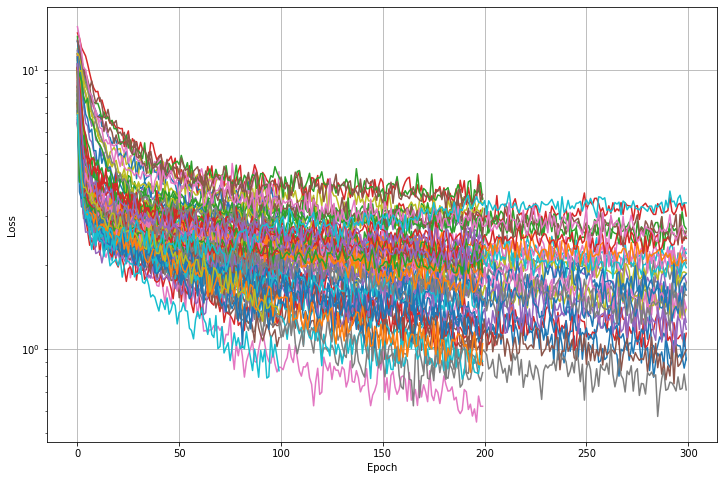

BEST MODEL HYPERPARAMETERS:
{'Nh1': 50, 'Nh2': 75, 'drop': 0.17474747474747473, 'wd': 0.004534878508128582, 'lr': 0.00628029144183426, 'optim': 'adam', 'epochs': 200}


In [18]:
plt.figure(figsize=(12,8))
for model in model_list:
    plt.semilogy(model['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()
print('BEST MODEL HYPERPARAMETERS:')
print(model_list[best_model]['hp_dict'])

## Best Model
***
Let's initialize a Network with the the best hyperparameter found by GridSearch.
Then I will train it and later tests it's performances.

In [34]:
best_net, best_params = ModelFromHP(Net, model_list[best_model]['hp_dict'], device)

Network initialized


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.26575285         0.26575285       199: 100%|██████████| 200/200 [00:04<00:00, 48.38it/s]


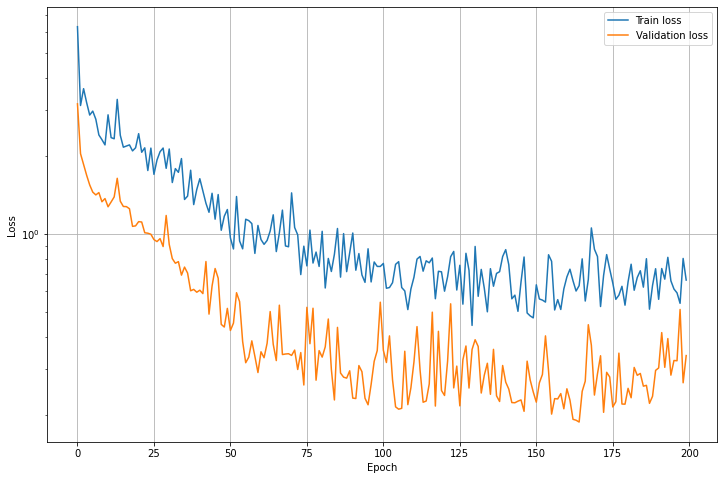

In [35]:
best_train_loss, best_val_loss = best_net.run_training(train_dataset, best_params, val_dataset=0.2, plot=True)

TEST LOSS = 0.41639918088912964


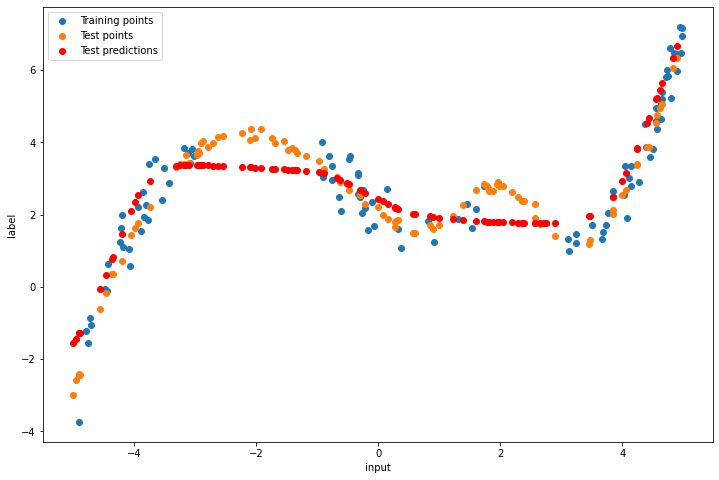

In [36]:
x_vec = torch.linspace(-5,5,1000)
x_vec = x_vec.to(device)
x_vec = x_vec.unsqueeze(-1)  # Adding a dimension to the input vector
trial_net.eval()
with torch.no_grad(): # turn off gradients computation
    y_vec = best_net(x_vec)
test_prediction, test_loss = best_net.run_test(test_dataset, best_params)
print('TEST LOSS = %s' % float(test_loss))
fig = plt.figure(figsize=(12,8))
plt.scatter(np.array(train_dataset.data)[:,0], np.array(train_dataset.data)[:,1], label='Training points')
plt.scatter(np.array(test_dataset.data)[:,0], np.array(test_dataset.data)[:,1], label='Test points')
plt.scatter(np.array(test_dataset.data)[:,0], test_prediction, label='Test predictions', c='r')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.show()

It's noticeable that the model now fits the data much better. Again the Network fails on the test data that lay inside the regions without training points: in those region the model was not able retrieve any information, nor learn how the data are distributed.


### Weight Visualization
***
Here I inspect the weight distribution for each trained model's layers.

In [37]:
## Access model parameters

# First hidden layer
h1_w = best_net.fc1.weight.data.cpu().numpy()
h1_b = best_net.fc1.bias.data.cpu().numpy()

# Second hidden layer
h2_w = best_net.fc2.weight.data.cpu().numpy()
h2_b = best_net.fc2.bias.data.cpu().numpy()

# Output layer
out_w = best_net.out.weight.data.cpu().numpy()
out_b = best_net.out.bias.data.cpu().numpy()

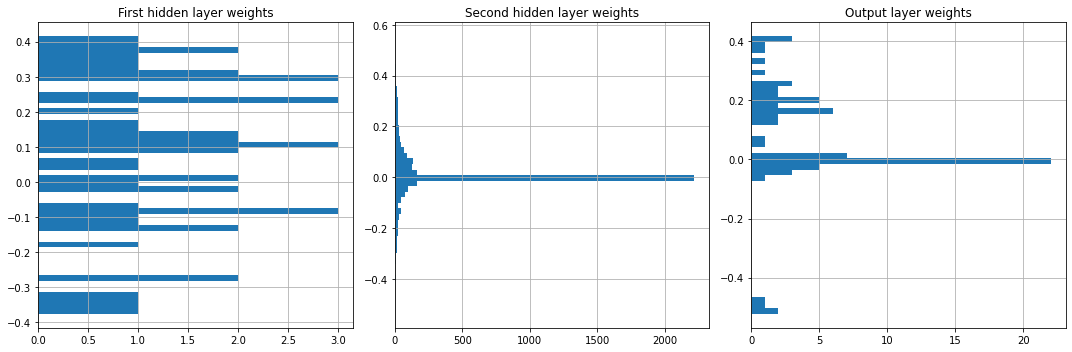

In [38]:
# Weights histogram
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].hist(h1_w.flatten(), 50, orientation='horizontal')
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50, orientation='horizontal')
axs[1].set_title('Second hidden layer weights')
axs[2].hist(out_w.flatten(), 50, orientation='horizontal')
axs[2].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

It can be seen that for the second hidden layer and the output one, the weight are distributed around the origin.

### Analysis of the layers' activation
***

In this section I'm going to visualize how the layer "reacts" to given inputs.

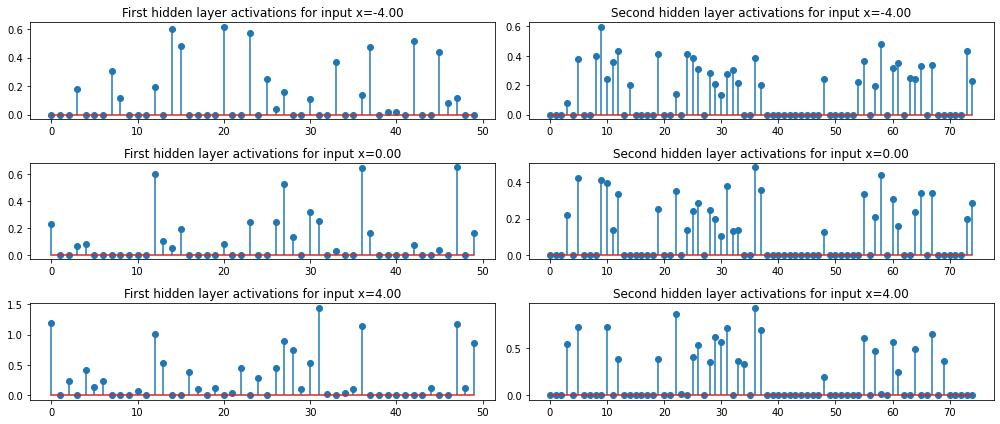

In [39]:
def get_activation1(layer, input, output):
    global activation1
    activation1 = torch.relu(output)
def get_activation2(layer, input, output):
    global activation2
    activation2 = torch.relu(output)


### Register hook  
hook_handle1 = best_net.fc1.register_forward_hook(get_activation1)
hook_handle2 = best_net.fc2.register_forward_hook(get_activation2)

### Analyze activations
best_net = best_net.to(device)
best_net.eval()
with torch.no_grad():
    x1 = torch.tensor([-4.]).float().to(device)
    y1 = best_net(x1)
    z1 = (activation1, activation2)
    x2 = torch.tensor([0.]).float().to(device)
    y2 = best_net(x2)
    z2 = (activation1, activation2)
    x3 = torch.tensor([4]).float().to(device)
    y3 = best_net(x3)
    z3 = (activation1, activation2)

### Remove hook
hook_handle1.remove()
hook_handle2.remove()

### Plot activations
fig, axs = plt.subplots(3, 2, figsize=(14,6))
for ii, (x,act) in enumerate(zip([x1,x2,x3],[z1,z2,z3])):
    axs[ii,0].stem(act[0].cpu().numpy(), use_line_collection=True)
    axs[ii,0].set_title('First hidden layer activations for input x=%.2f' % x)
    axs[ii,1].stem(act[1].cpu().numpy(), use_line_collection=True)
    axs[ii,1].set_title('Second hidden layer activations for input x=%.2f' % x)
plt.tight_layout()
plt.show()

It can be seen that almost half of the neurons are not firing at all, which is good and indicates the specificity of the neurons.